In [ ]:
# Add Google Drive as an accessible path (Optional if you are running from Jupyter Notebook)
from google.colab import drive
drive.mount('/content/drive')

# change path to the designated google drive folder
# otherwise, data will be saved in /content folder which you may have issue locating
%cd /content/drive/My Drive/Colab Notebooks/

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/Css project/Final


**Extraction**

In [ ]:
import tweepy
from tweepy import OAuthHandler

In [ ]:
# Consumer/Access key/secret/token obtained from Twitter
# You should have created a Twitter app and gotten these keys.
# Do NOT share your key/secret/token with other students.
consumer_key    = ''
consumer_secret = ''
access_token    = ''
access_secret   = 

In [ ]:
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

# This line finally calls Twitter's Rest API.
api = tweepy.API(auth)
#api = tweepy.API(auth,wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

# The following codes verify if the authentication is successful
# If all goes well, you should see a message saying Authentication OK.
# Otherwise, check your Consumer/Access key/secret/token
try:
    api.verify_credentials()
    print("Authentication OK")
except Exception as e:
    print("Error during authentication:", e)

CHANGE SEARCH WORD, DATE AND MAX TWEET HERE

In [ ]:
search_words = 'lgbt'
date_since = "2021-01-01" 

max_tweets = 1000

Get data from Alabama 32.318230,-86.902298 and California 33.90085,-117.51811

In [ ]:
new_search = search_words + " -filter:retweets" 
mypath = "."
# new_search has the value "clean energy -filter:retweets"
tweets = tweepy.Cursor(api.search, q=search_words, lang="en",geocode='32.318230,-86.902298,500km', since=date_since, tweet_mode='extended').items(max_tweets)
filename = f"{mypath}/tweets_{new_search}.jsons"

with open(filename, "w") as output:
    for tweet in tweets:
        myjson = tweet._json
        output.write(json.dumps(myjson)+"\n")





In [ ]:
#mounting current workboad into colab notebook folder > "." is the current location
filename = f"{mypath}/pro_tweets_{new_search}.jsons"
tweets_list = []
with open(filename) as fi:
    for line_cnt, line in enumerate(fi):
        tweet = json.loads(line.strip())

        tweetid = tweet['id']
        created_at = tweet['created_at']

        # Extract text from tweets in Extended Mode
        if 'retweeted_status' in tweet: # If it's Retweet
            text = tweet['retweeted_status']['full_text']
        else:  # Not a Retweet
            text = tweet['full_text']
        user_screen_name = tweet['user']['screen_name']
        user_location = tweet['user']['location']
        rt = tweet['retweet_count']
        fav = tweet['favorite_count']
        user_friend = tweet['user']['friends_count']

        tweets_list.append([user_screen_name,created_at, user_location,text,fav,rt,user_friend])

# populate dataframe with list of tweets
tweet_df = pd.DataFrame(data=tweets_list, columns=['user_screen_name','created_at','location','text','fav','rt_count','friend'])
tweet_df
      

In [ ]:
## save the data into a csv file
mypath= "."
tweet_df.to_csv(f'{mypath}/.csv', index=False)

Get data from California


1.   Check CSV file
2.   remove empty 'body' columns
3.   fill empty username with 'null_username')



In [ ]:
import pandas as pd
import numpy as np
mypath= "."
filename = ""
df = pd.read_csv(f'{mypath}/{filename}.csv')

In [ ]:
df.info()

In [ ]:
df["location"].value_counts()

First round of cleaning

1.   Change text to string
2.   Lowercase for all
3.   Expand contractions
4.   Remove punctuations
5.   Remove digits in text



In [ ]:
# Apply a first round of text cleaning techniques
import re 
import string

#https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

def clean_text_round1(text):
    
    '''Make text lowercase, remove punctuation and remove words containing numbers.'''
    
    text = str(text)
    text = re.sub(r'@\S+','', text)
    text = re.sub(r'&amp\S+','', text)
    text = text.lower()

    text = re.sub(r"won\'t", "will not",text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"let\'s", "let us",text)
    # general
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will",text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am",text)


    text = re.sub('[%s]' % re.escape(string.punctuation), '',text)  #xing yu: remove punctuations. also help to remove '-' eg: input: same-sex -> output: samesex
    text = re.sub('\w*\d\w*', '', text) #xing yu: remove words that contain numbers
    text = re.sub(r'[^\w]', ' ',text) #remove \n
    text = re.sub(r'http\S+', '', text) #remove url
    text = re.sub(r'www\S+', '', text) #remove url 
   
    #removes digits in between texts
    return text


In [ ]:
df['clean_text_1'] = df['text'].apply(clean_text_round1)
df

Second round of cleaning remove stopwords

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.
def clean_text_round2(text):
    return ' '.join([word for word in text.split() if word not in (stop)])
#split the words by space and join the words if the word is not in stop

In [ ]:
df['clean_text_2'] = df['clean_text_1'].apply(clean_text_round2)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1051 entries, 0 to 1050
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_screen_name  1051 non-null   object
 1   created_at        1051 non-null   object
 2   location          1046 non-null   object
 3   text              1051 non-null   object
 4   fav               1051 non-null   int64 
 5   rt_count          1051 non-null   int64 
 6   friend            1051 non-null   int64 
 7   clean_text_1      1051 non-null   object
 8   clean_text_2      1051 non-null   object
dtypes: int64(3), object(6)
memory usage: 74.0+ KB


In [ ]:
mypath= "."
df.to_csv(f'{mypath}/cleaned_{filename}.csv', index=False)

Log odds 

In [ ]:
mypath= "."
filename = "" #use the cleaned one
df = pd.read_csv(f'{mypath}/{filename}.csv')
df.info()

In [ ]:
### Let's download ```smt203util.py``` Below code should download the file in the same folder where your jupyter notebook is. 
!wget https://raw.githubusercontent.com/anjisun221/css_codes/main/ay21t1/Lab03_text_analysis/smt203util.py
#wget download file from internet (download smt203util.py)

from smt203util import *

--2021-11-11 09:49:53--  https://raw.githubusercontent.com/anjisun221/css_codes/main/ay21t1/Lab03_text_analysis/smt203util.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3034 (3.0K) [text/plain]
Saving to: ‘smt203util.py.1’

smt203util.py.1     100%[===================>]   2.96K  --.-KB/s    in 0.001s  

2021-11-11 09:49:53 (3.15 MB/s) - ‘smt203util.py.1’ saved [3034/3034]



In [ ]:
## Create ```word_counts``` folder 
import os
os.makedirs('word_counts', exist_ok=True)

In [ ]:
# this function create a dictionary with word counts from dataframe 
def count_words_from_dataframe(df):
    result_dict = {}
    # iterate rows of dataframe 
    for index, row in df.iterrows():
        text = str(row['clean_text_2'])
        #return the text for each row
        
        # this will split a sentence into words 
        tokens = text.split()
        #split the sentence by space >> list
        
        # iterate each word and count the number of words it appears in each of the speech for the list of speech
        for i in range(0, len(tokens)):
            token = tokens[i]
            try:
                result_dict[token] += 1
            except KeyError:
                result_dict[token] = 1
                    
    return result_dict

In [ ]:
import csv

count_type = 'unigram'
## this function will return a dictionary of words and frequency
result = count_words_from_dataframe(df)
sorted_dic = ((k, result[k]) for k in sorted(result, key=result.get, reverse=True))
with open(f"./word_counts/{filename}_{count_type}_counts.csv", 'w') as fp:
      writer = csv.writer(fp, delimiter=',')
      writer.writerows(sorted_dic)

In [ ]:
### Import relevant libraries
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import numpy as np
import re
from PIL import Image
from os import path
import csv

### this function will creat wordcloud based on word frequencies and save them into files under plot. 
def makeImage(termDict, outputfile):
    
    wc = WordCloud(max_font_size=60, width=1280, height=720, background_color="white")    

    ### generate word cloud using frequencies!
    wc.generate_from_frequencies(termDict)
    wc.to_file(outputfile+".png")
    wc.to_file(outputfile+".pdf")
    
    ### show the figure
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show() 
    

In [ ]:
### Create ```plot``` folder 
os.makedirs('plot', exist_ok=True)

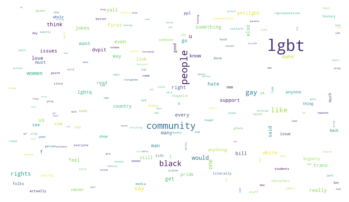

In [ ]:

### We're using one of the utility function! "read_word_count_file"
fullTermsDict = read_word_count_file(f'{mypath}/word_counts/{filename}_unigram_counts.csv')
outputfile = f"./plot/wordcloud_count_unigram_{filename}"
makeImage(fullTermsDict, outputfile)


In [ ]:
def count_bigrams_from_dataframe(df):
    
    result_dict = {}                    
    for index, row in df.iterrows():
        text = row['clean_text_2']
        tokens = str(text).split()
        for i in range(0, len(tokens)-1):
          token = tokens[i] + " " + tokens[i+1]
          try:
              result_dict[token] += 1
          except KeyError:
              result_dict[token] = 1

        ## write your code 
        
    return result_dict


import csv
count_type = 'bigram'

result = count_bigrams_from_dataframe(df)
    

## soring the words based on their frequency
sorted_dic = ((k, result[k]) for k in sorted(result, key=result.get, reverse=True))

## write the dictionary in a file
with open(f"./word_counts/{filename}_{count_type}_counts.csv", 'w') as fp:
    writer = csv.writer(fp, delimiter=',')
    writer.writerows(sorted_dic)

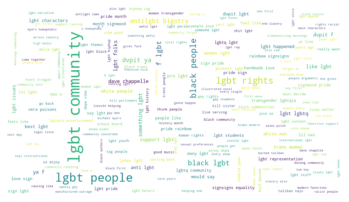

In [ ]:
#word cloud with bigram
### We're using one of the utility function! "read_word_count_file"
fullTermsDict = read_word_count_file(f'{mypath}/word_counts/{filename}_bigram_counts.csv')
outputfile = f"./plot/wordcloud_count_bigram_{filename}"
makeImage(fullTermsDict, outputfile)

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
### Getting global word counts (frequency of unigram in Google News datasets)
target_url = "https://raw.githubusercontent.com/anjisun221/css_codes/main/ay21t1/Lab03_text_analysis/1gram_englishall_count.csv"
global_counts = read_word_count_file_online(target_url)
print("The number of unigrams=", len(global_counts))

### Removing stopwords from the word list and 
stopwords_list = get_stopwords()
global_counts = {k: v for k, v in global_counts.items() if (k not in stopwords_list) and (len(k) > 2)}
print("After excluding stop words: ", len(global_counts))


The number of unigrams= 2280738
After excluding stop words:  2278940


In [ ]:
counts_i_name ='protected_LGBT'

counts_i = read_word_count_file(f"{mypath}/word_counts/{counts_i_name}_unigram_counts.csv")

### we filter out words that doesnt exist in our background corpus
counts_i_dict = {k: v for k, v in counts_i.items() if k in global_counts}
#check whether that word is in global_count

In [ ]:
counts_j_name = 'non_protected_LGBT'

counts_j = read_word_count_file(f"{mypath}/word_counts/{counts_j_name}_unigram_counts.csv")

### we filter out words that exist in our background corpus
counts_j_dict = {k: v for k, v in counts_j.items() if k in global_counts}

In [ ]:
### this function will return log-odds values. 
top_words_df = calculate_log_odds_idp(global_counts, counts_i_name, counts_i_dict, counts_j_name, counts_j_dict)

In [ ]:
### Below function will simply help you to print the above table into file, so that we can use it for drawing word cloud. 
### The output of this function is a csv file where each row contains (word, log_odds_z_score) for the two corpora. 
### threshold_i and threshold_j are the threshold of word frequency. 
### num_i and num_j are the number of representative words it will write in file. 
find_discriminative_words(top_words_df, threshold_i=10, threshold_j=10, num_i=20, num_j=20, mypath='.')
#larger dataset > set higher threshold

In [ ]:

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import numpy as np
import re
from PIL import Image
from os import path
import csv
 
### this function will creat wordcloud based on word frequencies and save them into files under plot. 
def makeImage(termDict, outputfile):

    wc = WordCloud(width=500, height=300, background_color="black",colormap="Blues")    
 
    ### generate word cloud using frequencies!
    wc.generate_from_frequencies(termDict)
    wc.to_file(outputfile+".png")
    wc.to_file(outputfile+".pdf")
    
    ### show the figure
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show() 
    

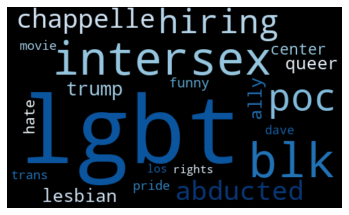

In [ ]:
### Create ```plot``` folder 
os.makedirs('plot', exist_ok=True)
 
filename = counts_i_name

### We're using one of the utility function! "read_word_count_file"
fullTermsDict = read_word_count_file(f'{mypath}/{filename}_zscore.csv')
outputfile = f"./plot/wordcloud_count_zscore_{filename}"
makeImage(fullTermsDict, outputfile)

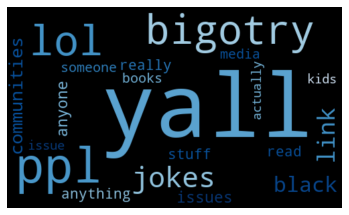

In [ ]:
### Create ```plot``` folder 
os.makedirs('plot', exist_ok=True)
 
filename = counts_j_name

### We're using one of the utility function! "read_word_count_file"
fullTermsDict = read_word_count_file(f'{mypath}/{filename}_zscore.csv')
outputfile = f"./plot/wordcloud_count_zscore_{filename}"
makeImage(fullTermsDict, outputfile)

**Classification**

In [ ]:
# Packages for data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Packages for train/test dataset split
from sklearn.model_selection import train_test_split

# Uncomment below if you want to see errors in more detail.
import os 
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


In [ ]:
!pip install datasets transformers[sentencepiece]

In [ ]:
## This will enable your coLab to use GPU!!! 
import torch
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [ ]:
mypath= "."
filename = ""
df = pd.read_csv(f'{mypath}/{filename}.csv')
df.info()


In [ ]:
df['Aspect'].value_counts()

In [ ]:
sentences = list(df['clean_text_1'].iloc[0:200].values)
y_str = list(df['Aspect'].iloc[0:200].values)

In [ ]:
len(y_str)
len(sentences)

In [ ]:
pred_sentences = list(df['clean_text_1'].values)
len(pred_sentences)

In [ ]:
y = []
for i in range(len(y_str)):
    if y_str[i] == "pro-lgbt":
        y.append(0)
      
    elif y_str[i] == "anti-lgbt":
        y.append(1)
  
    elif y_str[i] == "neutral":
        y.append(2) 

In [ ]:
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.20, random_state=999)

In [ ]:
len(sentences_test)

In [ ]:
sentences_train, sentences_val, y_train, y_val = train_test_split(sentences_train, y_train, test_size=.2, random_state=999)

In [ ]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [ ]:
train_encodings = tokenizer(sentences_train, truncation=True, padding=True)
val_encodings = tokenizer(sentences_val, truncation=True, padding=True)
test_encodings = tokenizer(sentences_test, truncation=True, padding=True)

In [ ]:
import torch

class myDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)



In [ ]:
train_dataset = myDataset(train_encodings, y_train)
val_dataset = myDataset(val_encodings, y_val)
test_dataset = myDataset(test_encodings, y_test)

In [ ]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=40,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)



In [ ]:
# if it's not a binary classification, num_labels should be given! 
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

trainer.train()

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

trainer.evaluate()

In [ ]:
trainer.save_model()

In [ ]:
new_model = DistilBertForSequenceClassification.from_pretrained("./results", num_labels=3)

new_trainer = Trainer(
    model=new_model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

In [ ]:
# create dataset for prediction
new_encodings = tokenizer(pred_sentences, truncation=True, padding=True)
# create dummy labels with the number of sentences to predict. 
y_new = np.full(len(pred_sentences), 1)
new_dataset = myDataset(new_encodings, y_new)

In [ ]:
new_predictions = new_trainer.predict(new_dataset)

In [ ]:
new_preds = np.argmax(new_predictions.predictions, axis=-1)
sump = 0
sumn = 0
sumneg = 0
for i in new_preds:
  if i == 0:
    sump += 1
  elif i == 1:
    sumneg += 1
  else:
    sumn += 1
print(f'There are {sump} pro-lgbt comments, {sumneg} anti-lgbt comments and {sumn} neutral comments')

In [ ]:
df['Prediction'] = new_preds.tolist()

In [ ]:
def add_predictions(pred):
  if pred == 0:
    pred = 'pro-lgbt'
  elif pred == 1:
    pred = 'anti-lgbt'
  else:
    pred = 'neutral'
  return pred 

In [ ]:
df['Prediction'] = df['Prediction'].apply(add_predictions)
df.head()

In [ ]:
df['Prediction'].value_counts()

In [ ]:
df.to_csv(f'{mypath}/.csv', index=False)

ZERO SHOT CLASSIFICATION (Not used in report)

In [ ]:
y_aspect_true = list(df['aspect'].values) # true labels (aspect)
y_aspect_true = y_aspect_true[0:200]

In [ ]:
from transformers import pipeline
sentences = list(df['clean_text_1'].values)

In [ ]:
# We extract text and label to build the model
aspect_classifier = pipeline("zero-shot-classification", device=0)
aspect_result = aspect_classifier(list(sentences), candidate_labels=['pro-lgbt',"anti-lgbt","neutral"],)


No model was supplied, defaulted to facebook/bart-large-mnli (https://huggingface.co/facebook/bart-large-mnli)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
aspect_result

[{'labels': ['anti-lgbt', 'neutral', 'pro-lgbt'],
  'scores': [0.9935190677642822, 0.004378156736493111, 0.0021027897018939257],
  'sequence': 'from ctmagazine ghana is one of  african nations where homosexuality is criminalized   major church networks and politicians have backed a controversial bill to ban lgbt advocacy groups and increase penalties for samesex relationships   '},
 {'labels': ['pro-lgbt', 'neutral', 'anti-lgbt'],
  'scores': [0.9725825190544128, 0.015316374599933624, 0.012101104483008385],
  'sequence': ' a doctor listening to meletting me ask for treatmentnot being ableist  anti lgbtinvestigating whats causing symptomsmaking sure my specialists are decentlistening to my input on medstreatmentsgoing the extra mile to make sure i got meds wo delay'},
 {'labels': ['pro-lgbt', 'neutral', 'anti-lgbt'],
  'scores': [0.9699699282646179, 0.015646202489733696, 0.014383911155164242],
  'sequence': 'a doctor listening to meletting me ask for treatmentnot being ableist  anti lgb

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
y_aspect_pred = [result['labels'][np.argmax(result['scores'])] for result in aspect_result]

y_aspect_pred_D= y_aspect_pred[0:200]

In [ ]:
count_dict = {'Pro-lgbt':0,'Anti-lgbt':0,'Neutral':0}
sump = 0
sumn = 0
sumneg = 0
for i in y_aspect_pred:
  if i == 'pro-lgbt':
    sump += 1
    count_dict['Pro-lgbt'] += 1
  elif i == 'anti-lgbt':
    sumneg += 1
    count_dict['Anti-lgbt'] += 1
  else:
    sumn += 1
    count_dict['Neutral'] += 1
print(f'There are {sump} supportive comments, {sumneg} unsupportive comments, {sumn} neutral comments')

There are 395 supportive comments, 362 unsupportive comments, 69 neutral comments


In [ ]:
# using classification_report to evaluate the predicted labels.
print(classification_report(y_aspect_true, y_aspect_pred))


              precision    recall  f1-score   support

   anti-lgbt       0.22      0.82      0.34        33
     neutral       0.80      0.04      0.08        94
    pro-lgbt       0.47      0.45      0.46        73

    accuracy                           0.32       200
   macro avg       0.50      0.44      0.29       200
weighted avg       0.58      0.32      0.26       200



In [ ]:
y_aspect_pred[0]
#protected_dict = {'Pro-lgbt':226,'Anti-lgbt':170,'Neutral':401}
#unprotected_dict = {'Pro-lgbt':231,'Anti-lgbt':105,'Neutral':194}

**Making Barchart**

In [ ]:
print(round(226/797 * 100,2))
print(round(170/797 * 100,2))
print(round(401/797 * 100,2))
print(round(231/530 *100,2))
print(round(105/530*100 ,2))
print(round(194/530*100,2))

28.36
21.33
50.31
43.58
19.81
36.6


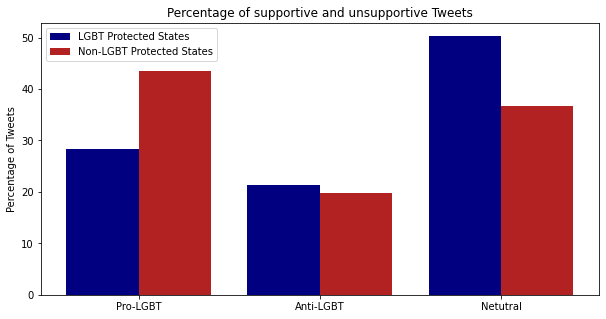

In [ ]:
fig = plt.figure(figsize = (10, 5))
X = ['Pro-LGBT', 'Anti-LGBT', 'Netutral']
pro = [28.36,21.33,50.31]
anti = [43.58,19.81,36.6]
X_axis = np.arange(len(X))
plt.bar(X_axis - 0.2, pro, 0.4, label = 'LGBT Protected States',color ='Navy')
plt.bar(X_axis + 0.2, anti, 0.4, label = 'Non-LGBT Protected States',color ='Firebrick')
# creating the bar plot
 
plt.xticks(X_axis, X)
plt.ylabel("Percentage of Tweets")
plt.title("Percentage of supportive and unsupportive Tweets")
plt.legend()
plt.show()
fig.savefig('usa.png')